In [1]:
import utility
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import train_test_split

# NOTES AND TODO

# compare the actual and predicton in some way (ratio or subtraction)
# investigate the confusion matrix
# investigate the most "confused" items
# use coefficients from LR to reduce features for future models, and iterate 
# use tables to track parameters to the results from the models
# https://jalammar.github.io/explaining-transformers/

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maxnbf/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Featurization
----
In this notebook we aim to featurize the data, and train a linear regression models. First we read in the `cleaned.csv` and extract the text descriptions to create our 'corpus'

In [2]:
df = pd.read_csv("cleaned.csv")
corpus = list(df["description"])

df.head()

,annual_salary,description
0,48880.0,many industries hurt last years people still n...
1,39500.0,Provide clerical administrative support manage...
2,100000.0,United Staffing Solutions partnering one bigge...
3,38000.0,looking responsible Administrative Assistant p...
4,144000.0,REMOTE WORK HOME COMMISSION PER ORDER REMOTE W...


Here we tokenize the descriptions, and calculate the number of tokens, to help visualize the data we are working with

In [3]:
df["description"] = df["description"].apply(utility.tokenize)
df["len"] = df["description"].apply(utility.lengths)
df.head()

,annual_salary,description,len
0,48880.0,"[many, industries, hurt, last, years, people, ...",163
1,39500.0,"[Provide, clerical, administrative, support, m...",62
2,100000.0,"[United, Staffing, Solutions, partnering, one,...",55
3,38000.0,"[looking, responsible, Administrative, Assista...",105
4,144000.0,"[REMOTE, WORK, HOME, COMMISSION, PER, ORDER, R...",93


Plot a histogram of the lengths. A majority of descriptions appear to have less than 500 tokens 

<Axes: ylabel='Frequency'>

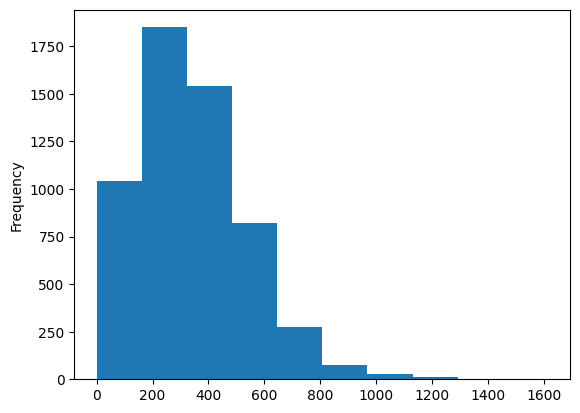

In [4]:
df["len"].plot.hist()

TF-IDF
----
Our first featurization technique is using a TF-IDF Matrix

In [5]:
tfidf_vectorizer = TfidfVectorizer() 
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus) 

X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, list(df["annual_salary"]), random_state=42)

Create and fit the model using the training data on a LinearRegression, Ridge and Lasso models

In [6]:
lasso = Lasso()
lasso.fit(X_train, y_train)

Lasso()

In [7]:
linear = LinearRegression()
linear.fit(X_train, y_train)

LinearRegression()

In [8]:
ridge = Ridge()
ridge.fit(X_train, y_train)

Ridge()

Here we sample predicting some of salaries in the `LinearRegression` model and compare them

In [9]:
for i in range(5):
    pred = linear.predict(X_test[i])[0]
    act = y_test[i]
    delta = abs(pred - act)
    print(str(i+1), ": Actual salary - ", str(act), ", Predicted Salary: ", str(pred), ", Delta: ", str(delta))

1 : Actual salary -  51750.0 , Predicted Salary:  -28181.386220303015 , Delta:  79931.38622030301
2 : Actual salary -  55000.0 , Predicted Salary:  90407.4981531973 , Delta:  35407.4981531973
3 : Actual salary -  36000.0 , Predicted Salary:  64448.16185127025 , Delta:  28448.161851270248
4 : Actual salary -  54000.0 , Predicted Salary:  99548.1138348997 , Delta:  45548.113834899705
5 : Actual salary -  36000.0 , Predicted Salary:  39626.26115228496 , Delta:  3626.261152284962


Then we calculate MSE MAE, and the percent of predictions within $5,000 and $10,000 on all three models, on both the training and testing data. This will allow us to analyze our results and check for overfitting.

In [10]:
print("LASSO MODEL")
lasso_preds = utility.predict_and_analyze(lasso, X_test, y_test)
_ = utility.predict_and_analyze(lasso, X_train, y_train)

print("LINEAR MODEL")
linear_preds = utility.predict_and_analyze(linear, X_test, y_test)
_ = utility.predict_and_analyze(linear, X_train, y_train)

print("RIDGE MODEL")
ridge_preds = utility.predict_and_analyze(ridge, X_test, y_test)
_ = utility.predict_and_analyze(ridge, X_train, y_train)

LASSO MODEL
Mean Squared Error (MSE): 1615192362.902232
Mean Absolute Error: 27046.68741580657
Percent of postings predicted within $5,000:  15.98
Percent of postings predicted within $10,000:  30.69
Mean Squared Error (MSE): 100157706.8245045
Mean Absolute Error: 7506.711304915931
Percent of postings predicted within $5,000:  41.32
Percent of postings predicted within $10,000:  73.56
LINEAR MODEL
Mean Squared Error (MSE): 2997238939.7076163
Mean Absolute Error: 38470.65377967874
Percent of postings predicted within $5,000:  13.58
Percent of postings predicted within $10,000:  23.06
Mean Squared Error (MSE): 327503.18760540383
Mean Absolute Error: 26.763427786407664
Percent of postings predicted within $5,000:  99.95
Percent of postings predicted within $10,000:  99.95
RIDGE MODEL
Mean Squared Error (MSE): 1353298470.5960977
Mean Absolute Error: 24436.254015543327
Percent of postings predicted within $5,000:  15.91
Percent of postings predicted within $10,000:  30.76
Mean Squared Error

We can see the `LinearRegression` model is extremely overfit, the `Lasso` model is overfit, and `Ridge` model is very minimally overfit.

Here we save the coefficients for each feature calculated by the best model, which will be Ridge, for now. This coefficeints resemble the correlation and magnitude that each feature has in determining the target values. We will use this coefficients in the future to reduce the number of features we use. 

In [11]:
coefs = ridge.coef_

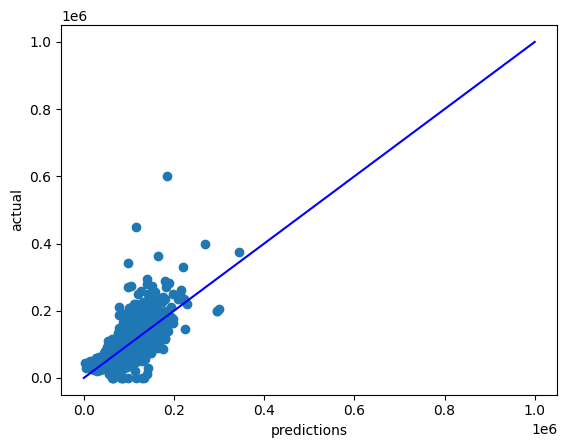

In [12]:
plt.scatter(ridge_preds, y_test)

x = range(0, 1000000)

plt.plot(x, x, c="b")
plt.xlabel('predictions')
plt.ylabel('actual')

plt.show()

As we can see in the plot above, there are many outliers that fall far from the line, and as these numbers are in the six figures, when calculating MSE, the value can become very high, which clearly accounts for the high MSE. This has a similar effect on the R-squared value.


Let's try and use the `coefs` we saved above to extract the most important feautres and retrain the model and compare the scores. Currently we are using 56,824 features, so we will use much smaller sets. 

In [13]:
number_of_features = [10000, 20000, 30000, 40000, tfidf_matrix.shape[1]]

for n in number_of_features:
    coefficeints = coefs
    temp_corpus = corpus

    # get the top features based on the coefficients with the largest magnitude
    features = tfidf_vectorizer.get_feature_names_out()
    coefficeints = np.array([abs(c) for c in coefficeints])
    top_features_indeces = coefficeints.argsort()[-n:][::-1]
    top_features = features[top_features_indeces]

    # filter the text descriptions
    filtered_corpus = utility.filter_corpus_by_vocabulary(corpus, top_features)

    # can see the filtered corpuses
    # print(corpus[0])
    # print(filtered_corpus[0])

    # retrain the matrix with only the top features
    tfidf_vectorizer_reduced = TfidfVectorizer() 
    tfidf_matrix_reduced = tfidf_vectorizer_reduced.fit_transform(filtered_corpus) 

    X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix_reduced, list(df["annual_salary"]), random_state=42)

    model = Ridge()
    model.fit(X_train, y_train)

    print("Testing for ", n, " features")
    utility.predict_and_analyze(model, X_test, y_test)

    # format as a DF where row is number of features, and columns are metrics

Testing for  10000  features
Mean Squared Error (MSE): 1548002705.4226756
Mean Absolute Error: 27184.87081506571
Percent of postings predicted within $5,000:  13.30
Percent of postings predicted within $10,000:  27.51
Testing for  20000  features
Mean Squared Error (MSE): 1528838927.968028
Mean Absolute Error: 26945.691423813565
Percent of postings predicted within $5,000:  14.50
Percent of postings predicted within $10,000:  27.86
Testing for  30000  features
Mean Squared Error (MSE): 1516552941.0135787
Mean Absolute Error: 26768.467685591233
Percent of postings predicted within $5,000:  14.43
Percent of postings predicted within $10,000:  27.51
Testing for  40000  features
Mean Squared Error (MSE): 1510426765.525079
Mean Absolute Error: 26692.360163273774
Percent of postings predicted within $5,000:  14.85
Percent of postings predicted within $10,000:  27.93
Testing for  56824  features
Mean Squared Error (MSE): 1509634017.821144
Mean Absolute Error: 26655.747038083555
Percent of pos

In [14]:
# features = tfidf_vectorizer.get_feature_names_out()
# df_tfidfvect = pd.DataFrame(data = tfidf_matrix.toarray(),columns = features)
# df_tfidfvect.head()

Bag of Words
----
We will next try to perform the similar strategies above to BoW featurization and see how the predictions compare

In [15]:
#bag of words
def featurize(vocab, tokenized_data):

    # use min_df or max_features?
    vectorizer = CountVectorizer(vocabulary=vocab, binary=False,max_features=200)

    data = []
    
    for text in tokenized_data:
        data.append(" ".join(text))

    X = vectorizer.fit_transform(data)

    return X.toarray(), vectorizer.get_feature_names_out()

featurized_data, count_vectorizer_vocab = featurize(None, list(df["description"]))


print(len(count_vectorizer_vocab))

200


In [16]:
X_train, X_test, y_train, y_test = train_test_split(featurized_data, list(df["annual_salary"]))

print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

4240
1414
4240
1414


In [17]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [18]:
index = 9
pred = model.predict([X_test[index]])

print(y_test[index], pred[0])

49000.0 66084.46372454634


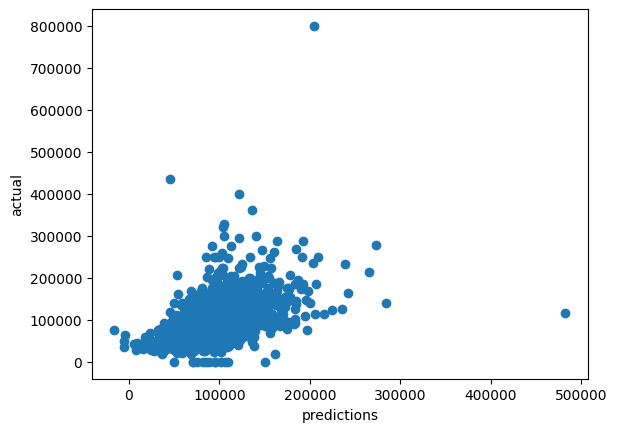

In [19]:
preds = model.predict(X_test)

#from sklearn.metrics import mean_squared_error 
#mean_squared_error(y_test, preds)
import matplotlib.pyplot as plt

# Sample data

# Create a scatter plot
plt.scatter(preds, y_test)

# Add labels and title
plt.xlabel('predictions')
plt.ylabel('actual')

# Show the plot
plt.show()

In [20]:
len(preds)

1414